### Steps:
- Simulate with BIMP with constant task cycle_times (output: MXML log)
- Transform MXML to XES
- Inject patterns (Change durations by Updating timestamps) 
- Add noise and save a separate noisy logs
- Adapt both normal and noisy logs based on given threshold
- Encode traces and save an encoded 

In [88]:
import time

# get the start time
start_time_code = time.process_time()

In [89]:
from IPython.display import Image

SKIP_ACTIVITY, INSERT_ACTIVITY = 'skip-activity', 'insert-activity'
ADAPTATIONS = [SKIP_ACTIVITY, INSERT_ACTIVITY]

ADAPTATION_TYPE = SKIP_ACTIVITY
LOGS_DIR = '../logs/simulation-models/'
LOG_NAME = 'sample_sequence_simulation_logs'
LOG_PATH = LOGS_DIR + LOG_NAME + '.xes'
TRANSFORMED_LOG_PATH = LOGS_DIR + LOG_NAME + '_transformed.xes'

raw_data_file_name = LOGS_DIR + LOG_NAME + '_adapted.csv'
noisy_data_file_name = LOGS_DIR + LOG_NAME + '_adapted_noisy.csv'

raw_data_object_file_path = LOGS_DIR + LOG_NAME + '_event_logs_patterned.pickle'
noisy_data_object_file_path = LOGS_DIR + LOG_NAME + '_event_logs_noisy.pickle'

Image(filename=LOGS_DIR + 'sample_sequence.png') 

%store ADAPTATIONS

%store LOGS_DIR
%store raw_data_file_name
%store noisy_data_file_name

Stored 'ADAPTATIONS' (list)
Stored 'LOGS_DIR' (str)
Stored 'raw_data_file_name' (str)
Stored 'noisy_data_file_name' (str)


In [90]:
# Thanks to: https://realpython.com/python-xml-parser/
from xml.dom.minidom import parse

logs_raw = parse(LOG_PATH)

print('sample trace:')
print(logs_raw.getElementsByTagName("trace")[0].toprettyxml())

sample trace:
<trace>
	<string key="concept:name" value="192"/>
	<string key="LogType" value="MXML.EnactmentLog"/>
	<event>
		<string key="elementId" value="process_start_event"/>
		<string key="concept:name" value="process start event"/>
		<string key="processId" value="Process_sample_sequence"/>
		<string key="lifecycle:transition" value="assign"/>
		<date key="time:timestamp" value="2022-08-16T17:00:00.000Z"/>
	</event>
	<event>
		<string key="elementId" value="process_start_event"/>
		<string key="concept:name" value="process start event"/>
		<string key="processId" value="Process_sample_sequence"/>
		<string key="lifecycle:transition" value="start"/>
		<date key="time:timestamp" value="2022-08-16T17:00:00.000Z"/>
	</event>
	<event>
		<string key="elementId" value="process_start_event"/>
		<string key="concept:name" value="process start event"/>
		<string key="processId" value="Process_sample_sequence"/>
		<string key="lifecycle:transition" value="complete"/>
		<date key="time:time

### Transfrom logs: put "assign" timestamps for "start" events and remove "assign" events

In [91]:
from xml.dom.minidom import Node
from datetime import datetime

def has_key_value(element=None, key=None, value=None):
    return (element.getAttribute("key") == key and element.getAttribute("value") == value)


def contains_string_element_with_key_value(element=None, key=None, value=None):
    strings = element.getElementsByTagName("string")
    for string_element in strings:
            if has_key_value(string_element, key, value):
                return True

    return False

def get_date(element):
    time_stamp_string = element.getElementsByTagName("date")[0].getAttribute("value")
    return datetime.fromisoformat(time_stamp_string.replace('Z', '+00:00'))


def set_date(element, date_string):
    element.getElementsByTagName("date")[0].setAttribute("value", date_string)

def get_string_element_by_key(element=None, key=None):
    strings = element.getElementsByTagName("string")
    for string_element in strings:
        if string_element.getAttribute("key") == key:
            return string_element

    return None

def get_string_element_value_by_key(element=None, key=None):
    string_element = get_string_element_by_key(element, key)

    if string_element is None:
        return None

    return string_element.getAttribute("value")

def set_string_element_value_by_key(element=None, key=None, value='NA'):
    strings = element.getElementsByTagName("string")
    for string_element in strings:
        if string_element.getAttribute("key") == key:
            return string_element.setAttribute("value", value)

    return None

def write_to_file_xml(file_path, root_node):
    file_handle = open(file_path,"w")
    root_node.writexml(file_handle, indent='\t',  addindent='\t', newl='\n')
    file_handle.close()

def remove_adapted_suffix_in_name(event):
    key = 'concept:name'
    event_concept_name = get_string_element_value_by_key(event, key)
    first_part_of_name = event_concept_name.split('-')[0]
    set_string_element_value_by_key(element=event, key=key, value=first_part_of_name)

# loop over all traces
traces = logs_raw.getElementsByTagName("trace")
for trace in traces:
    # get all events
    events = trace.getElementsByTagName("event")
    # loop on events
    for event in events:

        # get rid of all "Z"s in timestamps
        without_z_timestamp = event.getElementsByTagName("date")[0].getAttribute("value").replace('Z', '+00:00')
        set_date(event, without_z_timestamp)

        # if event is "assign" get timestamp
        
        if contains_string_element_with_key_value(event, 'lifecycle:transition', 'assign'): # it is an assign event
           
            assign_timestamp = event.getElementsByTagName("date")[0].getAttribute("value").replace('Z', '+00:00')
            
            event_concept_name = get_string_element_value_by_key(event, 'concept:name')
            
            # find next event with the same concept:name
            for ev in events:
                # if event is "start" replace timestamp with the one from "assign"
                if contains_string_element_with_key_value(ev, 'lifecycle:transition', 'start') and \
                   contains_string_element_with_key_value(ev, 'concept:name', event_concept_name):
                    set_date(ev, assign_timestamp)

            # remove assign event
            event.parentNode.removeChild(event)

        # if contains_string_element_with_key_value(event, 'lifecycle:transition', 'start'): # it is start event
        #     # remove start event
        #     event.parentNode.removeChild(event)

        # remove elementId attribute from event
        elementId_element = get_string_element_by_key(element=event, key='elementId')
        event.removeChild(elementId_element)

        # remove '-adapted...' suffix from activity names
        remove_adapted_suffix_in_name(event)
    
write_to_file_xml(TRANSFORMED_LOG_PATH, logs_raw)

### Read Transformed log and store in a list

In [92]:
from xml.dom.minidom import parse

# read transformed log
logs_xes = parse(TRANSFORMED_LOG_PATH)

In [93]:
# extract all data and store in a list

event_logs = []

# loop over all traces
traces = logs_xes.getElementsByTagName("trace")
for trace in traces:

    trace_id = int(trace.getElementsByTagName("string")[0].getAttribute("value"))
    trace_obj = {'trace_id': trace_id, 'events': []}
    
    # get all events
    events = trace.getElementsByTagName("event")
    # loop on events
    for event in events:
        # name, start_time, end_time, resource, cost
        
        start_event = contains_string_element_with_key_value(event, 'lifecycle:transition', 'start')

        if not start_event:
            continue
        
        # if this is start event: 1) set start_time 2) search for the complete event 3) set attributes based on complete event
        # else (this is complete event): continue

        start_time = get_date(event)
        name = get_string_element_value_by_key(event, 'concept:name')
        
        # now we look for end_time, resource, and cost in the corresponding complete event
        for ev in events:
            # if event is "complete" and related then extract fields
            if contains_string_element_with_key_value(ev, 'lifecycle:transition', 'complete') and \
               contains_string_element_with_key_value(ev, 'concept:name', name):
                # this is a related complete event
                end_time = get_date(ev)
                resource = get_string_element_value_by_key(ev, 'org:resource')
                cost = get_string_element_value_by_key(ev, 'resourceCost')
                cost = 0 if cost is None else float(cost)
                    
                not_found = False
                

        event_obj = {'name': name, 'start_time': start_time, 'end_time': end_time, 'resource': resource, 'cost': cost}
        trace_obj['events'].append(event_obj)
    
    event_logs.append(trace_obj)

# sort traces from 0 to the end
event_logs = sorted(event_logs, key=lambda trace_dic: trace_dic['trace_id'])

print('sample trace:')
print(event_logs[0])


sample trace:
{'trace_id': 0, 'events': [{'name': 'process start event', 'start_time': datetime.datetime(2022, 8, 1, 9, 0, tzinfo=datetime.timezone.utc), 'end_time': datetime.datetime(2022, 8, 1, 9, 0, tzinfo=datetime.timezone.utc), 'resource': None, 'cost': 0}, {'name': 'A', 'start_time': datetime.datetime(2022, 8, 1, 9, 0, tzinfo=datetime.timezone.utc), 'end_time': datetime.datetime(2022, 8, 1, 9, 30, tzinfo=datetime.timezone.utc), 'resource': 'Default Resource-000001', 'cost': 12.5}, {'name': 'B', 'start_time': datetime.datetime(2022, 8, 1, 9, 30, tzinfo=datetime.timezone.utc), 'end_time': datetime.datetime(2022, 8, 1, 10, 0, tzinfo=datetime.timezone.utc), 'resource': 'Default Resource-000003', 'cost': 12.5}, {'name': 'C', 'start_time': datetime.datetime(2022, 8, 1, 10, 0, tzinfo=datetime.timezone.utc), 'end_time': datetime.datetime(2022, 8, 1, 10, 30, tzinfo=datetime.timezone.utc), 'resource': 'Default Resource-000006', 'cost': 12.5}, {'name': 'D', 'start_time': datetime.datetime(2

### Inject Pattern (Update task durations with (increase and decrease) pattern)

In [94]:
def store_obj_in_file(obj, file_path):
    import pickle
    file_to_store = open(file_path, "wb")
    pickle.dump(obj, file_to_store)
    file_to_store.close()

def shift_consecutive_events(trace_events, event_index, time_shift):
    #shift all timestamps after this event
    for ev_index, ev in enumerate(trace_events):
        if ev_index > event_index:
            ev['start_time'] += time_shift
            ev['end_time'] += time_shift

def generate_patterned_logs(logs):
    from datetime import timedelta
    import copy

    start_time_patterned_logs = time.process_time()

    # patterns in task durations in minutes
    activities_with_pattern = ['B','C']
    b_list = [30,40,50,60,50,40]
    c_list = [30,60,90,60]
    patterns = {'B':b_list,
                'C':c_list}

    event_logs_patterned = copy.deepcopy(logs)

    #remove cost (could be considered later)
    for trace in event_logs_patterned:
        for event in trace['events']:
            event.pop('cost', None)

    num_traces = len(event_logs_patterned)

    for trace in event_logs_patterned:
        
        trace_events = trace['events']

        for event_index, event in enumerate(trace_events):

            activity_name = event['name']
            trace_id = trace['trace_id']
            
            old_duration = event['end_time'] - event['start_time']
            new_duration_minutes = old_duration.total_seconds()/60

            # assign cycle_times with patterns if patterned task
            if activity_name in activities_with_pattern:
                pattern_length = len(patterns[activity_name])
                new_duration_minutes = patterns[activity_name][trace_id % pattern_length]
            
            new_duration = timedelta(minutes=new_duration_minutes)

            #shift end time of this event
            time_shift = new_duration - old_duration
            event['end_time'] = event['end_time'] + time_shift

            shift_consecutive_events(trace_events, event_index, time_shift)

    end_time_patterned_logs = time.process_time()
    print('Patterned logs generation CPU time:', end_time_patterned_logs - start_time_patterned_logs, 'seconds')
    return event_logs_patterned

event_logs_patterned = generate_patterned_logs(event_logs)
store_obj_in_file(event_logs_patterned, raw_data_object_file_path)

Patterned logs generation CPU time: 0.6875 seconds


### Add noise to patterned logs and save as a separate noisy logs

In [95]:
start_time_adding_noise = time.process_time()

import random
random.seed(10)
noise_percentage_max = 20

def add_noise(logs):
    from datetime import timedelta
    from statistics import mean
    import copy
    
    noise_values = []

    noisy_logs = copy.deepcopy(logs)

    for trace in noisy_logs:
        
        trace_events = trace['events']

        for event_index, event in enumerate(trace_events):

            activity_name = event['name']
            trace_id = trace['trace_id']
            
            # update activity duration
            old_duration = event['end_time'] - event['start_time']
            new_duration_minutes = old_duration / timedelta(minutes=1)

            noise = random.uniform(-new_duration_minutes, new_duration_minutes) * random.uniform(0, noise_percentage_max / 100) # +-[0-noise_percentage]
            new_duration_minutes += noise

            noise_values.append(abs(noise))

            new_duration = timedelta(minutes=new_duration_minutes)

            #shift end time of this event
            time_shift = new_duration - old_duration
            event['end_time'] = event['end_time'] + time_shift

            shift_consecutive_events(trace_events, event_index, time_shift)
        
    print('noise absolute values mean:', mean(noise_values))
                    
    return noisy_logs

noisy_logs = add_noise(event_logs_patterned)

end_time_adding_noise = time.process_time()
print('Adding noise CPU time:', end_time_adding_noise - start_time_adding_noise, 'seconds')

store_obj_in_file(noisy_logs, noisy_data_object_file_path)

noise absolute values mean: 3.8772256999061954
Adding noise CPU time: 0.859375 seconds


### Adapt traces using the time threshold

In [96]:
def adapt_case(skippable_activity_name, trace):
    # this implementation skips the skippable activity in a given trace
    for event_index, event in enumerate(trace):
        if event['name'] == skippable_activity_name:
            skippable_activity_duration = event['end_time'] - event['start_time']
                    #update consequent timestamps
            time_shift = skippable_activity_duration
            shift_consecutive_events(trace, event_index, time_shift)
                    #remove activity from the events
            trace.pop(event_index)

def adapt_logs(logs, cycle_time_threshold, skippable_activity_name):

    num_traces = len(logs)
    num_adapted_traces = 0
    
    for trace in logs:
        trace_events = trace['events']
        trace_cycle_time = trace_events[-1]['end_time'] - trace_events[0]['start_time']
        # set adapted flag
        trace['adapted'] = trace_cycle_time > cycle_time_threshold
        
        # do the adaptation if the threshold is violated 
        if trace['adapted']:
            num_adapted_traces += 1
            adapt_case(skippable_activity_name, trace_events)

    print('Adapted traces percentage:', 100 * num_adapted_traces/num_traces)
    return logs

from datetime import timedelta

cycle_time_threshold = timedelta(hours=4, minutes=10)
skippable_activity_name = 'E'

event_logs_adapted = adapt_logs(event_logs_patterned, cycle_time_threshold, skippable_activity_name)
noisy_logs_adapted = adapt_logs(noisy_logs, cycle_time_threshold, skippable_activity_name)

Adapted traces percentage: 41.5
Adapted traces percentage: 41.3


In [97]:
def logs_to_dict(logs):

    from datetime import timedelta
    all_events = []

    for trace in logs:
        
        trace_events = trace['events']

        for event_index, event in enumerate(trace_events):
            event_dict = {'trace_id':trace['trace_id']}
            event_dict['event_name'] = event['name']
            event_dict['start_time'] = event['start_time']
            event_dict['start_weekday'] = event['start_time'].weekday()
            event_dict['end_time'] = event['end_time']
            event_dict['duration'] = (event['end_time'] - event['start_time']) / timedelta(minutes=1)
            event_dict['resource'] = 'NA' if event['resource'] == None else event['resource']
            event_dict['adapted'] = trace['adapted']
            all_events.append(event_dict)
    
    return all_events

### store logs to csv files (adapted.csv and adapted_noisy.csv)

In [98]:
def write_to_file_csv(file_name, data_dic):
    import csv

    with open(file_name, mode='w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = list(data_dic[0].keys()))
        writer.writeheader()
        writer.writerows(data_dic)

raw_data = logs_to_dict(event_logs_adapted)
write_to_file_csv(raw_data_file_name, raw_data)

noisy_data = logs_to_dict(noisy_logs_adapted)
write_to_file_csv(noisy_data_file_name, noisy_data)

### Encode data (from events of traces to data rows, each trace -> one row)

In [99]:
def encode_data(input_csv_file_name, output_csv_file_name):
    import pandas as pd
    import pm4py
    from pm4py.algo.transformation.log_to_features import algorithm as log_to_features
    from datetime import timedelta

    print('Encoding logs to:', output_csv_file_name)

    dataframe = pd.read_csv(input_csv_file_name, sep=',')
    dataframe = pm4py.format_dataframe(dataframe, case_id='trace_id', activity_key='event_name', 
                                        start_timestamp_key='start_time', timestamp_key='end_time')
    event_log = pm4py.convert_to_event_log(dataframe)

    data, feature_names = log_to_features.apply(event_log)

    df = pd.DataFrame(data, columns=feature_names)
    
    cycle_times = []

    grouped_traces = dataframe.groupby(by='trace_id')
    for name, group in grouped_traces:
        trace_cycle_time = (group.iloc[-1]['end_time'] - group.iloc[0]['start_time']) / timedelta(minutes=1)
        cycle_times.append(trace_cycle_time)

    # traces_data = pd.concat([dataframe.groupby(by='trace_id').head(1)['start_time'].sort_values(ascending=True).reset_index(drop=True), dataframe.groupby(by='trace_id').tail(1)['end_time'].sort_values(ascending=True).reset_index(drop=True)], axis=1, keys=['start', 'end'])
    # traces_data['duration'] = traces_data['end'] - traces_data['start']
    
    df['trace:cycle_time'] = cycle_times
    df['adapted'] = dataframe.groupby(by='trace_id')['adapted'].min()
    df.index.name = 'trace_id'

    df.to_csv(output_csv_file_name)

raw_data_encoded_output_file_name = LOGS_DIR + LOG_NAME + '_adapted_encoded.csv'
noisy_data_encoded_output_file_name = LOGS_DIR + LOG_NAME + '_adapted_noisy_encoded.csv'

encode_data(raw_data_file_name, raw_data_encoded_output_file_name)
encode_data(noisy_data_file_name, noisy_data_encoded_output_file_name)
print('Encoding done!')

Encoding logs to: ../logs/simulation-models/sample_sequence_simulation_logs_adapted_encoded.csv
Encoding logs to: ../logs/simulation-models/sample_sequence_simulation_logs_adapted_noisy_encoded.csv
Encoding done!


### Validation

In [100]:
def measure_log_fitness_percentage(logs):
    import pm4py

    net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(logs)
    pm4py.view_petri_net(net, initial_marking, final_marking)

    replayed_traces = pm4py.conformance_diagnostics_token_based_replay(logs, net, initial_marking, final_marking)

    num_traces_in_logs = len(logs)
    num_traces_fit = 0

    for replayed_trace in replayed_traces:
        if replayed_trace['trace_is_fit'] == True:
            num_traces_fit += 1
    
    return (num_traces_fit * 100) / num_traces_in_logs

parsing log, completed traces :: 100%|██████████| 1000/1000 [00:02<00:00, 430.85it/s]


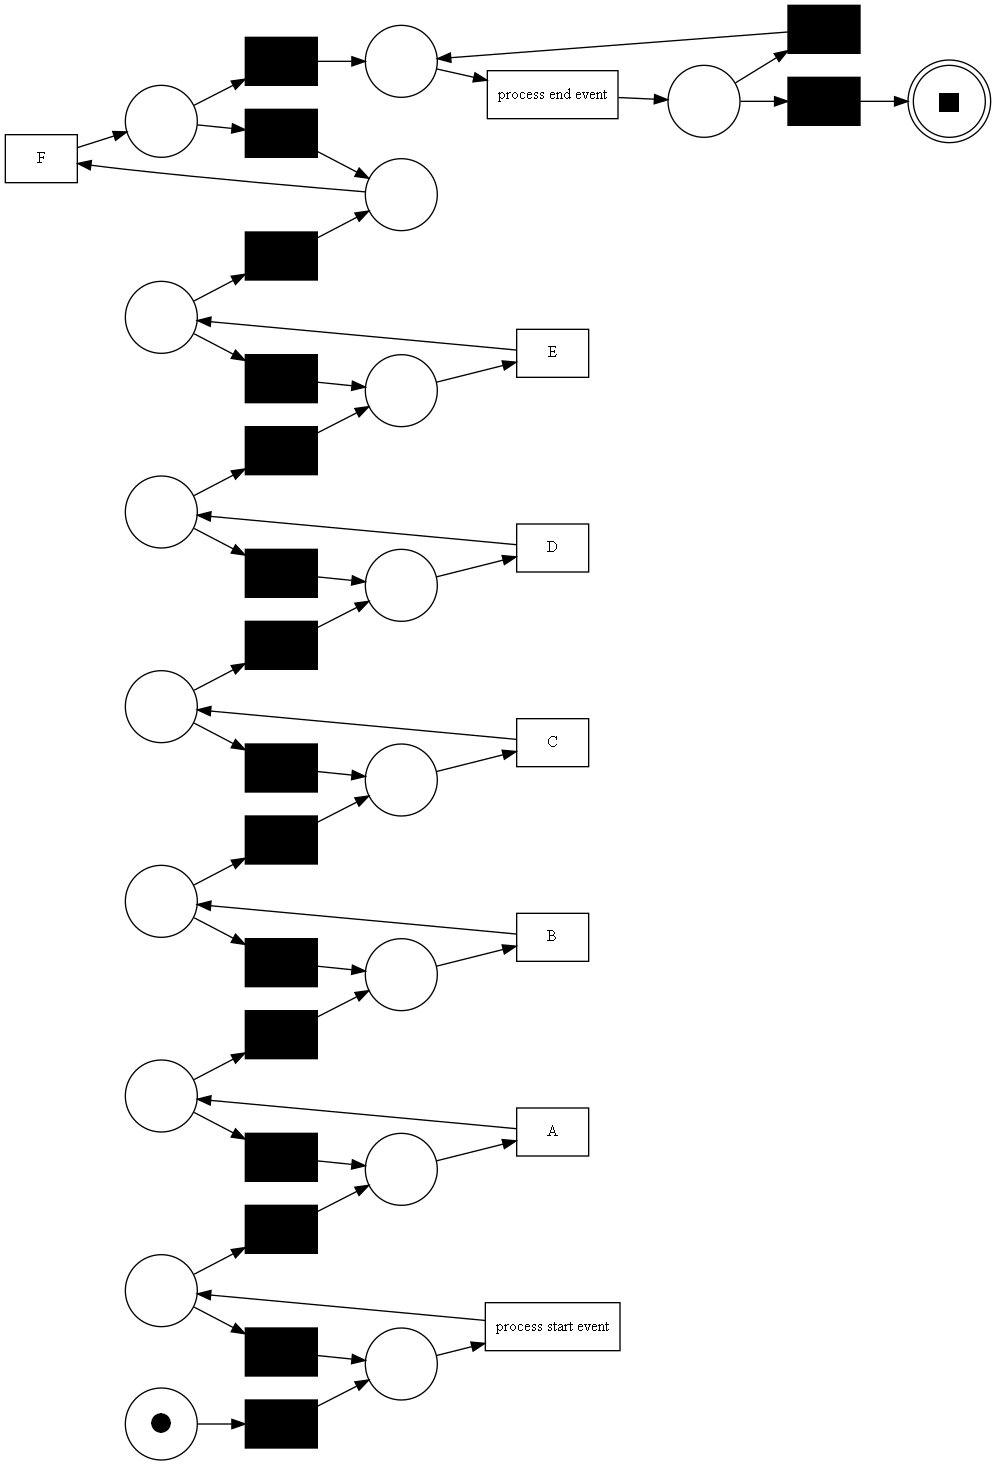

Transformed logs fitness percentage: 100.0


In [101]:
import pm4py

transformed_logs = pm4py.read_xes(TRANSFORMED_LOG_PATH)
transformed_logs_fitness_percentage = measure_log_fitness_percentage(transformed_logs)
print('Transformed logs fitness percentage:', transformed_logs_fitness_percentage)

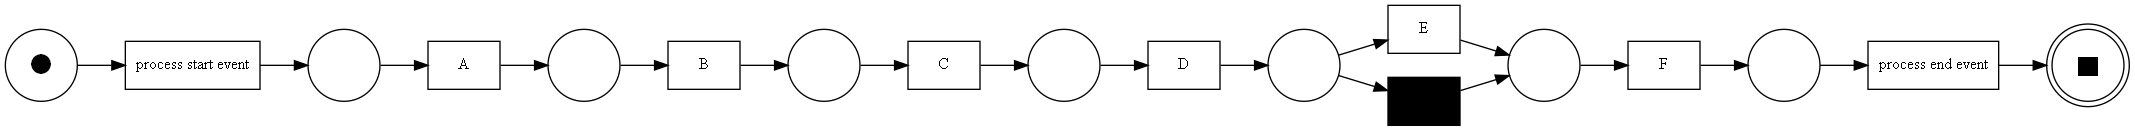

replaying log with TBR, completed variants :: 100%|██████████| 2/2 [00:00<00:00, 59.68it/s]


Raw logs fitness percentage: 100.0


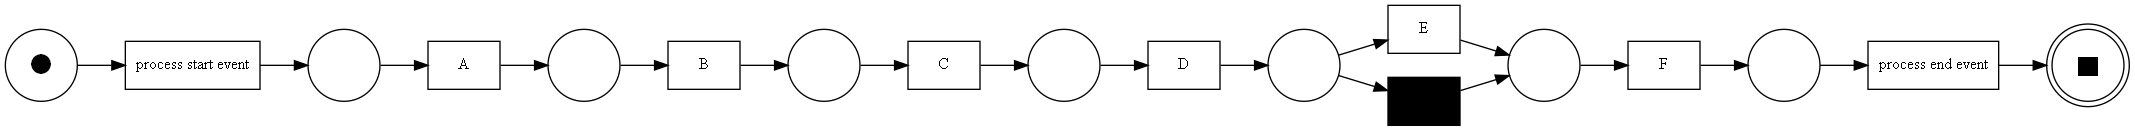

replaying log with TBR, completed variants :: 100%|██████████| 2/2 [00:00<00:00, 62.43it/s]

Noisy logs fitness percentage: 100.0


In [102]:
def measure_fitness_percentage_csv_file(log_path):
    import pandas as pd
    import pm4py

    dataframe = pd.read_csv(log_path)
    dataframe = pm4py.format_dataframe(dataframe, case_id='trace_id', activity_key='event_name', timestamp_key='end_time')
    event_logs = pm4py.convert_to_event_log(dataframe)
    fitness_percentage = measure_log_fitness_percentage(event_logs)
    return fitness_percentage

print('Raw logs fitness percentage:', measure_fitness_percentage_csv_file(raw_data_file_name))
print('Noisy logs fitness percentage:', measure_fitness_percentage_csv_file(noisy_data_file_name))

In [103]:
# get the end time
end_time_code = time.process_time()

# get CPU time
cpu_time = end_time_code - start_time_code
print('CPU Execution time:', cpu_time, 'seconds')

CPU Execution time: 56.46875 seconds
